## 3D domain identify 
refer to tutorial https://stagate.readthedocs.io/en/latest/T5_3D.html  
2025/01/03 modified by Zhenna Jiao 

### workflow
* 1. use STAGATE to identify the embryo 3D domain 
* 2. annotation NC cell as head_NC PA3_NC and Pos_NC acrooding to there coordinates distribution  

In [1]:
import datetime 
current_date = datetime.datetime.now().strftime("%B %d, %Y")
current_time = datetime.datetime.now().strftime("%I:%M %p")
current_date + ", "+current_time

'January 03, 2025, 03:33 PM'

In [2]:
import torch_geometric
print(torch_geometric.__version__)

2.6.1


In [3]:
import STAGATE_pyG

In [ ]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

: 

In [2]:
pip install matplotlib matplotlib_venn

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for matplotlib_venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45404 sha256=8733922506ab7b5683505d00a9164c1485da24c2fb673f7bce1f632b5aa1fbf6
  Stored in directory: c:\users\zhaoj\appdata\local\pip\cache\wheels\c2\47\0c\f014c55a1cfd56dce41a1cafd23e3c590652b5e71330cc181c
Successfully built matplotlib_venn
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


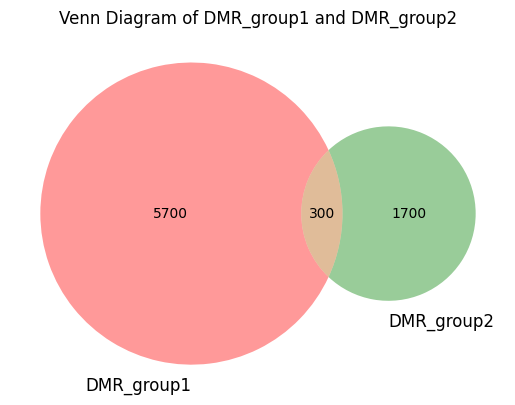

In [3]:

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# 定义两组数据的大小和交集
group1_size = 6000
group2_size = 2000
intersection_size = 300

# 计算各自独立的部分
only_group1 = group1_size - intersection_size
only_group2 = group2_size - intersection_size

# 绘制韦恩图
venn2(subsets=(only_group1, only_group2, intersection_size), set_labels=('DMR_group1', 'DMR_group2'))

# 显示图形
plt.title("Venn Diagram of DMR_group1 and DMR_group2")
plt.show()

## Read  filter h5ad data  cotain 3D alignment coordinates 

In [ ]:
adata =sc.read_h5ad("/home/jiaozhenna/projects/merscope/run6/analysis/tangram/results/filter_results/R56_filter_m3_retry_add_NC_states_20250103.h5ad")
adata

In [ ]:
adata.obs["cell_type_NC_states"].value_counts()

## using whole run data to do domain identify

## Run5

In [ ]:
#ad_sp = adata[(adata.obs['run'] == "run5")].copy()
ad_sp = adata.copy()
ad_sp =  ad_sp[ad_sp.obsm["spatial3d_stim"].sum(axis=1) != 0]
sc.pp.normalize_total(ad_sp, target_sum=1e4)
sc.pp.log1p(ad_sp)

In [ ]:
ad_sp.obsm["spatial_old"] = ad_sp.obsm["spatial"].copy()
    
    # 获取 spatial3d 中的 X 和 Y 坐标
spatial_2d_from_spatial3d = ad_sp.obsm["spatial3d_stim"][:, :2]
    
    # 创建一个新的 DataFrame 来保存新的坐标，并保证索引对齐
spatial_2d_df = pd.DataFrame(spatial_2d_from_spatial3d, index=ad_sp.obs.index, columns=['X', 'Y'])
    
    # 更新 spatial_old 中的坐标
ad_sp.obsm["spatial"] = spatial_2d_df.values
    ## do plot to check the sptail 
sc.pl.embedding(ad_sp,basis="spatial",color="leiden_res2")
    
    ## define section order 
section_order = ["slice1","slice2","slice3","slice4","slice5","slice6"]

In [ ]:
num_Rcluster=20 
rad_cutoff_2D=18
STAGATE_pyG.Cal_Spatial_Net_3D(ad_sp, rad_cutoff_2D=rad_cutoff_2D, rad_cutoff_Zaxis=10,
                               key_section='slice_id', section_order = section_order, verbose=True)
    ## plot the data the average neighbor of each cell
STAGATE_pyG.Stats_Spatial_Net(ad_sp)
    ## train SNN
STAGATE_pyG.train_STAGATE(ad_sp,save_loss=True,save_reconstrction=True,hidden_dims=[128, 30])

In [ ]:
 ## umap for the SNN output data 
sc.pp.neighbors(ad_sp, use_rep='STAGATE',random_state=1223)
sc.tl.umap(ad_sp,random_state=1223)
sc.tl.tsne(ad_sp,random_state=1223)
 ## cluster 
num_cluster = num_Rcluster ## this parameter can be adjust
ad_sp = STAGATE_pyG.mclust_R(ad_sp, num_cluster, used_obsm='STAGATE')
 ## slice color
ad_sp.uns['slice_id_colors'] = ['#02899A', '#0E994D', '#86C049', '#FBB21F', '#F48022', '#DA5326', '#BA3326']
 
 ## do plot 
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(ad_sp, color=['mclust', 'slice_id'])
sc.pl.embedding(ad_sp, color=['mclust', "NC_states","cell_type"],basis="spatial")
    

In [ ]:
for i in range(1,14):
    sc.pl.embedding(ad_sp[(ad_sp.obs["embryo_id"]==f"embryo{i}") & (ad_sp.obs["run"]=="run5")], color=['mclust'],basis="spatial")

In [ ]:
numbers = list(range(1, 22)) +[24]+ [25]
for i in numbers:
    sc.pl.embedding(ad_sp[(ad_sp.obs["embryo_id"]==f"embryo{i}") & (ad_sp.obs["run"]=="run6")], color=['mclust'],basis="spatial")

### mannual annotaion 3D domain 
* domain1 : mclust : 14,19,4,2,18,9,8,16,11,5,20
* domain2 : mclust : 10,3,7,15,1,6,12,13,17

In [ ]:
adata.obs['STAGATE_cluster'] = np.nan 
adata.obs['STAGATE_cluster'] = adata.obs['STAGATE_cluster'].astype('category')

In [ ]:
adata.obs['STAGATE_cluster'] = adata.obs['STAGATE_cluster'].astype(str)
ad_sp.obs['mclust'] =ad_sp.obs['mclust'].astype(str)
print(ad_sp.obs['mclust'].head())
    
    # 获取共同索引
common_idx = ad_sp.obs.index.intersection(adata.obs.index)
print(f"common_idx: {len(common_idx)}")
    
    # 更新数据
adata.obs.loc[common_idx, 'STAGATE_cluster'] = ad_sp.obs.loc[common_idx, 'mclust']

In [ ]:
adata.obs["STAGATE_recluster"] = adata.obs["STAGATE_cluster"].copy()
adata

In [ ]:
## define 3D domain 
adata.obs.loc[(adata.obs["STAGATE_cluster"].isin(["14","19","4","2","18","9","8","16","11","5","20"])), "STAGATE_recluster"] = "1"
# adata_NC.obs.loc[(adata.obs["run"] == "run5") & (adata_NC.obs["embryo_id"] == "embryo9") & (adata_NC.obs["STAGATE_cluster"].isin([])), "STAGATE_recluster"] = "2"
adata.obs.loc[(adata.obs["STAGATE_cluster"].isin(["10","3","7","15","1","6","12","13","17"])), "STAGATE_recluster"] = "2"

## plot identified domain

In [ ]:
for i in range(1,14):
    ad_filter = adata[(adata.obs['embryo_id'] == f'embryo{i}') & (adata.obs['run'] == "run5")].copy()
    ad_filter =  ad_filter[ad_filter.obsm["spatial3d_stim"].sum(axis=1) != 0]
    sc.pl.embedding(ad_filter, color=['STAGATE_recluster'],basis="spatial3d_stim")

## plot Run5 NC_cell states

## plot ss3mapped NC 

In [ ]:
palette_list ={
    'Mutant_nohox_early_0': '#FB9A99',
     'mNC_hox34_1': '#EF595A',
     'mNC_head_mesenchymal_2': '#6A3D9A',
     'mNC_arch2_3': '#FFD700',
    'Pigment_4': '#00FFFF',
    'mNC_nohox_5': '#ffbb78',
     'Mutant_hox23_6': '#1f77b4',
    'mNC_vagal_7': '#ff7f0e',
    'Mutant_nohox_pigment_8': '#2ca02c',
    'Mutant_nohox_pigment_9': '#d62728',
    'dNC_nohox_10': '#9467bd',
     'NPB_nohox_11': '#e377c2',
     'mNC_arch1_12': '#8c564b',
     'NPB/Mut_nohox_13': '#7f7f7f',
     'NC_trunk_14': '#bcbd22',
     'Mutant_nohox_pigment_15': '#3000ff',
    'Mutant_nohox_pigment_16': '#8000ff',
     'mNC_vagal/dNC_nohox_17': '#191970',
    'mNC_vagal_18': '#76ee00',
    'mNC_head_mesenchymal_19': '#00ff00',
    'mNC_nohox_20': '#c0ff3e',
    'dNC_hoxa2b_21': '#ffa500',
    'Mutant_hox23_22':'#ff00ff',
    'dNC_hox34_23': '#ff0080',
    'Mutant_nohox_pigment_24': '#ffc1c1',
    "Mutant_nohox_pigment_25" : "#76eec6",
    'NPB_hox3_26': '#8c564b',
    # '27': '#191970',
    "N.A.":"#d3d3d3"
}

In [ ]:
sc.set_figure_params(figsize=(6,6))
for i in range(1,14):
    ad_filter = adata_NC[(adata_NC.obs['embryo_id'] == f'embryo{i}') & (adata_NC.obs['run'] == "run5")].copy()
    ad_filter =  ad_filter[ad_filter.obsm["spatial3d_stim"].sum(axis=1) != 0]
    sc.pl.embedding(ad_filter, color=['NC_Cell_Type_Cluster'],
                    basis="spatial3d_stim",
                    palette=palette_list)

## Run6

In [ ]:
numbers = list(range(1, 22)) +[24]+ [25]
for i in numbers:
    sc.pl.embedding(ad_sp[ad_sp.obs["embryo_id"]==f"embryo{i}"], color=['mclust'],basis="spatial")

In [ ]:
sc.set_figure_params(figsize=(4,4))
for i in numbers:
    ad_filter = adata[(adata.obs['embryo_id'] == f'embryo{i}') & (adata.obs['run'] == "run6")].copy()
    ad_filter =  ad_filter[ad_filter.obsm["spatial3d_stim"].sum(axis=1) != 0]
    sc.pl.embedding(ad_filter, color=['STAGATE_recluster'],basis="spatial3d_stim")

## do plot for NC cell states 

In [ ]:
for i in numbers:
    ad_filter = adata[(adata.obs['embryo_id'] == f'embryo{i}') & (adata.obs['run'] == "run6")].copy()
    ad_filter =  ad_filter[ad_filter.obsm["spatial3d_stim"].sum(axis=1) != 0]
    sc.pl.embedding(ad_filter, color=['NC_Cell_Type_Cluster'],basis="spatial3d_stim", palette=palette_list)

In [ ]:
adata

In [ ]:
sc.pl.umap(adata,color=["STAGATE_recluster"])


In [ ]:
adata.write_h5ad("/home/jiaozhenna/projects/merscope/run6/analysis/tangram/results/filter_results/R56_filter_m3_retry_add_NC_states_STAGATE_DOMAIN_20250103.h5ad")